In [1]:
#Image Classification Model

import glob
import cv2
import numpy as np
#Importing Training Data 

train1all = [cv2.imread(file) for file in glob.glob("C:/Users/Josh/Documents/UofC ChemE Content/BMEN 415 - Sensor and Data Analytics/Project Data/C-NMC_training_data/fold_0/all/*.bmp")]
train1hem = [cv2.imread(file) for file in glob.glob("C:/Users/Josh/Documents/UofC ChemE Content/BMEN 415 - Sensor and Data Analytics/Project Data/C-NMC_training_data/fold_0/hem/*.bmp")]
train2all = [cv2.imread(file) for file in glob.glob("C:/Users/Josh/Documents/UofC ChemE Content/BMEN 415 - Sensor and Data Analytics/Project Data/C-NMC_training_data/fold_1/all/*.bmp")]
train2hem = [cv2.imread(file) for file in glob.glob("C:/Users/Josh/Documents/UofC ChemE Content/BMEN 415 - Sensor and Data Analytics/Project Data/C-NMC_training_data/fold_1/hem/*.bmp")]
train3all = [cv2.imread(file) for file in glob.glob("C:/Users/Josh/Documents/UofC ChemE Content/BMEN 415 - Sensor and Data Analytics/Project Data/C-NMC_training_data/fold_2/all/*.bmp")]
train3hem = [cv2.imread(file) for file in glob.glob("C:/Users/Josh/Documents/UofC ChemE Content/BMEN 415 - Sensor and Data Analytics/Project Data/C-NMC_training_data/fold_2/hem/*.bmp")]

In [21]:
trainall = train1all +train2all +train3all
trainhem = train1hem +train2hem +train3hem

trainall = train1all +train2all +train3all
trainhem = train1hem +train2hem +train3hem
y_train = [1]*len(trainall) + [0]*len(trainhem) #Setting 1s to Leukemia Immature Cell and 0s to Normal Cell
x_train = trainall+trainhem
y_train = np.array(y_train)
x_train = np.array(x_train)

In [3]:
#Not Run for Final Testing as it Appeared to Decrease Accuracy by 2-3% 
print('Class Imbalance:', len(trainall), len(trainhem))  #Class imbalance

#Flipping Minor class sample to generate more samples
trainhemTemp = np.array(trainhem)
trainhemF = np.flipud(trainhemTemp) #Flip Vertically
#Adding In Augmented Data to Balance Classes
y_trainTemp = np.zeros(len(trainhemF)) #Labels 0 = Normal Cell
x_train = np.concatenate((x_train, trainhemF), axis=0)
y_train = np.concatenate((y_train, y_trainTemp), axis=0)

print('New Class Distribution', len(trainall), 2*len(trainhem))

Class Imbalance: 7272 3389
New Class Distribution 7272 6778


In [4]:
#Importing Testing Data (Needs to be Matched with Labels)
import pandas as pd

ylabels = pd.read_csv (r'C:/Users/Josh/Documents/UofC ChemE Content/BMEN 415 - Sensor and Data Analytics/Project Data/validation_data/C-NMC_test_prelim_phase_data_labels.csv')

x_test= []
y_test= []

for file in glob.glob("C:/Users/Josh/Documents/UofC ChemE Content/BMEN 415 - Sensor and Data Analytics/Project Data/validation_data/C-NMC_test_prelim_phase_data/*.bmp"):
    img= cv2.imread(file)
    x_test.append(img)
    index = np.where(ylabels ==file.split("\\")[1])[0]
    value = ylabels.iat[int(index), 2]
    y_test.append(value)   
                      


In [22]:
#Resizing Images to be Smaller
image = train1all[0]
resized_image = cv2.resize(image, dsize=(128,128), interpolation=cv2.INTER_CUBIC)
x_Strain = [resized_image]*len(x_train)
x_Stest = [resized_image]*len(x_test)

for n in range(len(x_train)):
    x_Strain[n] =  cv2.resize(x_train[n], dsize=(128,128), interpolation=cv2.INTER_CUBIC)

for i in range(len(x_test)):
    x_Stest[i] =  cv2.resize(x_test[i], dsize=(128,128), interpolation=cv2.INTER_CUBIC)
    

In [23]:
#Normalizing RBG Values
x_Strain = np.array(x_Strain)
x_Ntrain = x_Strain.astype("float32") / 255

x_Stest = np.array(x_Stest)
x_Ntest = x_Stest.astype("float32") / 255

print("x_Ntrain shape:", x_Ntrain.shape)
print(x_Ntrain.shape[0], "train samples")

x_Ntrain shape: (10661, 128, 128, 3)
10661 train samples


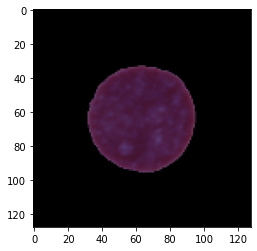

In [7]:

#Reviewing and Resizing Images To Be Smaller
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = x_Ntest[1]
imgplot = plt.imshow(image)
plt.show()


In [26]:
#Experimenting with One-Hot Encoding as Recommeneded by the TA's
y_train = np.array(y_train)
y_Htrain = np.empty([len(y_train),2])
y_Htrain[:,0] = y_train
y_Htrain[:,1]= 1-y_train

y_test = np.array(y_test)
y_Htest = np.empty([len(y_test),2])
y_Htest[:,0] = y_test
y_Htest[:,1]= 1-y_test

In [30]:
#Building the Model
from keras.layers import Activation, Dense, Dropout
from keras.models import Sequential 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_shape = x_Strain[1].shape #128, 128, 3

model = Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(layers.Flatten())
model.add(Dense(25))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('sigmoid'))

In [31]:
batch_size = 200
epochs = 10

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

training = model.fit(x_Ntrain, y_Htrain, batch_size=batch_size, epochs=epochs, validation_data=(x_Ntest,y_Htest))

Epoch 1/10
54/54 [==============================] - 19s 350ms/step - loss: 0.5035 - accuracy: 0.7803 - val_loss: 0.7064 - val_accuracy: 0.6984
Epoch 2/10
54/54 [==============================] - 18s 337ms/step - loss: 0.4491 - accuracy: 0.8092 - val_loss: 0.7228 - val_accuracy: 0.6995
Epoch 3/10
54/54 [==============================] - 19s 357ms/step - loss: 0.4370 - accuracy: 0.8094 - val_loss: 0.6453 - val_accuracy: 0.7140
Epoch 4/10
54/54 [==============================] - 20s 371ms/step - loss: 0.4276 - accuracy: 0.8192 - val_loss: 0.7052 - val_accuracy: 0.7092
Epoch 5/10
54/54 [==============================] - 23s 424ms/step - loss: 0.4171 - accuracy: 0.8268 - val_loss: 0.6649 - val_accuracy: 0.7070
Epoch 6/10
54/54 [==============================] - 27s 494ms/step - loss: 0.4135 - accuracy: 0.8242 - val_loss: 0.7233 - val_accuracy: 0.7102
Epoch 7/10
54/54 [==============================] - 25s 455ms/step - loss: 0.3997 - accuracy: 0.8335 - val_loss: 0.7189 - val_accuracy: 0.7076

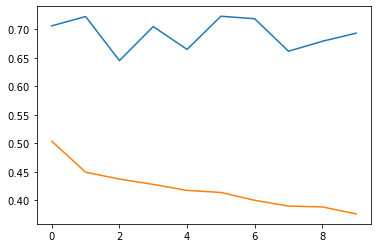

In [32]:
xl = list(range(epochs))
vy = training.history['val_loss']
ty = training.history['loss']

plt.plot( xl, vy,  label='Validation' )
plt.plot( xl, ty, label='Train' )
plt.show()


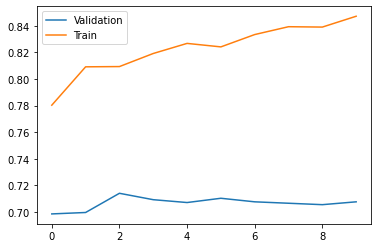

In [33]:
xl = list(range(epochs))
vy = training.history['val_accuracy']
ty = training.history['accuracy']

plt.plot( xl, vy,  label='Validation' )
plt.plot( xl, ty, label='Train' )
plt.legend()
plt.show()

In [34]:
model.evaluate(x_Ntest, y_Htest)

from sklearn.metrics import confusion_matrix
y_Hpred = model.predict(x_Ntest)
y_Hpred = np.round(y_Hpred, decimals=0)

confusion_matrix(y_Htest[:,0], y_Hpred[:,0])

59/59 [==============================] - 1s 25ms/step - loss: 0.6935 - accuracy: 0.7076


array([[ 164,  484],
       [  66, 1153]], dtype=int64)

In [38]:
#Initial Tests with Transfer Learning
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
import tensorflow as tf

base_model = InceptionV3(input_shape = (128, 128, 3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False
    
x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(2, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ["accuracy"])
training = model.fit(x_Ntrain, y_Htrain, batch_size=100, epochs=30, validation_data=(x_Ntest,y_Htest))

Epoch 1/30
107/107 [==============================] - 85s 754ms/step - loss: 0.7166 - acc: 0.7556 - val_loss: 0.7320 - val_acc: 0.6438
Epoch 2/30
107/107 [==============================] - 77s 724ms/step - loss: 0.4564 - acc: 0.8056 - val_loss: 0.6628 - val_acc: 0.6642
Epoch 3/30
107/107 [==============================] - 78s 725ms/step - loss: 0.4244 - acc: 0.8215 - val_loss: 0.6821 - val_acc: 0.6352
Epoch 4/30
107/107 [==============================] - 78s 734ms/step - loss: 0.4024 - acc: 0.8283 - val_loss: 0.6924 - val_acc: 0.6395
Epoch 5/30
107/107 [==============================] - 78s 733ms/step - loss: 0.3869 - acc: 0.8388 - val_loss: 0.6787 - val_acc: 0.6610
Epoch 6/30
107/107 [==============================] - 80s 745ms/step - loss: 0.3714 - acc: 0.8427 - val_loss: 0.7085 - val_acc: 0.6599
Epoch 7/30
107/107 [==============================] - 78s 732ms/step - loss: 0.3609 - acc: 0.8461 - val_loss: 0.7898 - val_acc: 0.6604
Epoch 8/30
107/107 [==============================] - 7